In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'VTCNN2_v2_mp'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [7]:
def I_Q_to_module_phase(signal):
    modules = []
    phases =[]
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)

        modules.append(abs(cmplx))
        phases.append(cmath.phase(cmplx))

    # return [module_1, module_2, ..., module_n], [phase_1, phase_2, ..., phase_n]
    return modules, phases

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_module_phase(signal)
    
    # transformed_signal is a <modules, phases> couple
    transformed_signals.append(transformed_signal)

In [9]:
module_phase_signals_column_dataframe_name = 'MP signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[module_phase_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    module_phase_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding Module/Phase signals

In [10]:
dataset_df

,IQ signals,MP signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","([0.009777415810077348, 0.008160794610184235, ...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","([0.006428271419970337, 0.0018729896699540463,...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","([0.006714471814517775, 0.010443807990507132, ...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","([0.0036471206082490607, 0.008847963411403753,...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","([0.01363757358555227, 0.004953662955395487, 0...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","([0.007888647836121875, 0.00518580783630137, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","([0.004378196387910148, 0.006676949935829746, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","([0.013097595344676685, 0.008587072893700217, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","([0.004868425922433083, 0.01011580181134021, 0...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = dataset_df[module_phase_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 2, 128)
[2, 128]


In [16]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 80)          0

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 31:12 - loss: 2.6521

  9/151 [>.............................] - ETA: 0s - loss: 2.5503   

 17/151 [==>...........................] - ETA: 0s - loss: 2.5058

 25/151 [===>..........................] - ETA: 0s - loss: 2.4757

 33/151 [=====>........................] - ETA: 0s - loss: 2.4532

 41/151 [=======>......................] - ETA: 0s - loss: 2.4357

 49/151 [========>.....................] - ETA: 0s - loss: 2.4215

 58/151 [==========>...................] - ETA: 0s - loss: 2.4084

 66/151 [============>.................] - ETA: 0s - loss: 2.3986

 75/151 [=============>................] - ETA: 0s - loss: 2.3891

 84/151 [===============>..............] - ETA: 0s - loss: 2.3809

 93/151 [=================>............] - ETA: 0s - loss: 2.3738

102/151 [===================>..........] - ETA: 0s - loss: 2.3674

111/151 [=====================>........] - ETA: 0s - loss: 2.3617

120/151 [======================>.......] - ETA: 0s - loss: 2.3565

129/151 [========================>.....] - ETA: 0s - loss: 2.3517

138/151 [==========================>...] - ETA: 0s - loss: 2.3473

147/151 [============================>.] - ETA: 0s - loss: 2.3431

151/151 [==============================] - ETA: 0s - loss: 2.3414

151/151 [==============================] - 14s 10ms/step - loss: 2.3410 - val_loss: 2.1866


Epoch 2/100
  1/151 [..............................] - ETA: 1s - loss: 2.2015

  9/151 [>.............................] - ETA: 0s - loss: 2.2131

 18/151 [==>...........................] - ETA: 0s - loss: 2.2111

 27/151 [====>.........................] - ETA: 0s - loss: 2.2089

 35/151 [=====>........................] - ETA: 0s - loss: 2.2066

 43/151 [=======>......................] - ETA: 0s - loss: 2.2047

 51/151 [=========>....................] - ETA: 0s - loss: 2.2029

 59/151 [==========>...................] - ETA: 0s - loss: 2.2012

 67/151 [============>.................] - ETA: 0s - loss: 2.1995

 76/151 [==============>...............] - ETA: 0s - loss: 2.1975



 84/151 [===============>..............] - ETA: 0s - loss: 2.1958

 93/151 [=================>............] - ETA: 0s - loss: 2.1941

101/151 [===================>..........] - ETA: 0s - loss: 2.1926

109/151 [====================>.........] - ETA: 0s - loss: 2.1912

118/151 [======================>.......] - ETA: 0s - loss: 2.1897

127/151 [========================>.....] - ETA: 0s - loss: 2.1882

135/151 [=========================>....] - ETA: 0s - loss: 2.1870

144/151 [===========================>..] - ETA: 0s - loss: 2.1856

151/151 [==============================] - 1s 7ms/step - loss: 2.1844 - val_loss: 2.0799


Epoch 3/100
  1/151 [..............................] - ETA: 1s - loss: 2.1112

  9/151 [>.............................] - ETA: 0s - loss: 2.1190

 18/151 [==>...........................] - ETA: 0s - loss: 2.1185

 26/151 [====>.........................] - ETA: 0s - loss: 2.1176

 35/151 [=====>........................] - ETA: 0s - loss: 2.1169

 44/151 [=======>......................] - ETA: 0s - loss: 2.1166

 53/151 [=========>....................] - ETA: 0s - loss: 2.1163

 62/151 [===========>..................] - ETA: 0s - loss: 2.1159

 71/151 [=============>................] - ETA: 0s - loss: 2.1155

 79/151 [==============>...............] - ETA: 0s - loss: 2.1150

 86/151 [================>.............] - ETA: 0s - loss: 2.1145

 94/151 [=================>............] - ETA: 0s - loss: 2.1139

101/151 [===================>..........] - ETA: 0s - loss: 2.1133

108/151 [====================>.........] - ETA: 0s - loss: 2.1126

114/151 [=====================>........] - ETA: 0s - loss: 2.1120

120/151 [======================>.......] - ETA: 0s - loss: 2.1115

127/151 [========================>.....] - ETA: 0s - loss: 2.1108

134/151 [=========================>....] - ETA: 0s - loss: 2.1103

140/151 [==========================>...] - ETA: 0s - loss: 2.1098

148/151 [============================>.] - ETA: 0s - loss: 2.1091

151/151 [==============================] - 1s 8ms/step - loss: 2.1088 - val_loss: 2.0266


Epoch 4/100
  1/151 [..............................] - ETA: 1s - loss: 2.0714

 10/151 [>.............................] - ETA: 0s - loss: 2.0785

 19/151 [==>...........................] - ETA: 0s - loss: 2.0751

 28/151 [====>.........................] - ETA: 0s - loss: 2.0732

 37/151 [======>.......................] - ETA: 0s - loss: 2.0721

 46/151 [========>.....................] - ETA: 0s - loss: 2.0710

 54/151 [=========>....................] - ETA: 0s - loss: 2.0703

 63/151 [===========>..................] - ETA: 0s - loss: 2.0696

 72/151 [=============>................] - ETA: 0s - loss: 2.0691

 81/151 [===============>..............] - ETA: 0s - loss: 2.0687

 90/151 [================>.............] - ETA: 0s - loss: 2.0683

 99/151 [==================>...........] - ETA: 0s - loss: 2.0679

108/151 [====================>.........] - ETA: 0s - loss: 2.0674

117/151 [======================>.......] - ETA: 0s - loss: 2.0670

125/151 [=======================>......] - ETA: 0s - loss: 2.0667

134/151 [=========================>....] - ETA: 0s - loss: 2.0663

143/151 [===========================>..] - ETA: 0s - loss: 2.0659

151/151 [==============================] - 1s 7ms/step - loss: 2.0656 - val_loss: 1.9994


Epoch 5/100
  1/151 [..............................] - ETA: 1s - loss: 2.0579

 10/151 [>.............................] - ETA: 0s - loss: 2.0501

 19/151 [==>...........................] - ETA: 0s - loss: 2.0528

 28/151 [====>.........................] - ETA: 0s - loss: 2.0526

 37/151 [======>.......................] - ETA: 0s - loss: 2.0515

 46/151 [========>.....................] - ETA: 0s - loss: 2.0507

 55/151 [=========>....................] - ETA: 0s - loss: 2.0500

 64/151 [===========>..................] - ETA: 0s - loss: 2.0493

 73/151 [=============>................] - ETA: 0s - loss: 2.0487

 82/151 [===============>..............] - ETA: 0s - loss: 2.0483

 91/151 [=================>............] - ETA: 0s - loss: 2.0478

 99/151 [==================>...........] - ETA: 0s - loss: 2.0474

107/151 [====================>.........] - ETA: 0s - loss: 2.0471

116/151 [======================>.......] - ETA: 0s - loss: 2.0467

125/151 [=======================>......] - ETA: 0s - loss: 2.0463

134/151 [=========================>....] - ETA: 0s - loss: 2.0459

143/151 [===========================>..] - ETA: 0s - loss: 2.0456

151/151 [==============================] - 1s 7ms/step - loss: 2.0453 - val_loss: 1.9892


Epoch 6/100
  1/151 [..............................] - ETA: 1s - loss: 2.0149

 10/151 [>.............................] - ETA: 0s - loss: 2.0278

 19/151 [==>...........................] - ETA: 0s - loss: 2.0293

 28/151 [====>.........................] - ETA: 0s - loss: 2.0285

 36/151 [======>.......................] - ETA: 0s - loss: 2.0283

 45/151 [=======>......................] - ETA: 0s - loss: 2.0284

 54/151 [=========>....................] - ETA: 0s - loss: 2.0280

 63/151 [===========>..................] - ETA: 0s - loss: 2.0279

 71/151 [=============>................] - ETA: 0s - loss: 2.0280

 80/151 [==============>...............] - ETA: 0s - loss: 2.0279

 89/151 [================>.............] - ETA: 0s - loss: 2.0277

 98/151 [==================>...........] - ETA: 0s - loss: 2.0275

107/151 [====================>.........] - ETA: 0s - loss: 2.0273

116/151 [======================>.......] - ETA: 0s - loss: 2.0272

125/151 [=======================>......] - ETA: 0s - loss: 2.0272

134/151 [=========================>....] - ETA: 0s - loss: 2.0271

143/151 [===========================>..] - ETA: 0s - loss: 2.0271

151/151 [==============================] - 1s 7ms/step - loss: 2.0270 - val_loss: 1.9813


Epoch 7/100
  1/151 [..............................] - ETA: 1s - loss: 1.9599

 10/151 [>.............................] - ETA: 0s - loss: 2.0088

 19/151 [==>...........................] - ETA: 0s - loss: 2.0099

 28/151 [====>.........................] - ETA: 0s - loss: 2.0106

 37/151 [======>.......................] - ETA: 0s - loss: 2.0120

 46/151 [========>.....................] - ETA: 0s - loss: 2.0128

 55/151 [=========>....................] - ETA: 0s - loss: 2.0134

 64/151 [===========>..................] - ETA: 0s - loss: 2.0138

 73/151 [=============>................] - ETA: 0s - loss: 2.0139

 82/151 [===============>..............] - ETA: 0s - loss: 2.0140

 91/151 [=================>............] - ETA: 0s - loss: 2.0141

100/151 [==================>...........] - ETA: 0s - loss: 2.0142

109/151 [====================>.........] - ETA: 0s - loss: 2.0143

118/151 [======================>.......] - ETA: 0s - loss: 2.0143

127/151 [========================>.....] - ETA: 0s - loss: 2.0142

136/151 [==========================>...] - ETA: 0s - loss: 2.0142

145/151 [===========================>..] - ETA: 0s - loss: 2.0142

151/151 [==============================] - 1s 7ms/step - loss: 2.0142 - val_loss: 1.9765


Epoch 8/100
  1/151 [..............................] - ETA: 1s - loss: 1.9767

 10/151 [>.............................] - ETA: 0s - loss: 1.9883

 19/151 [==>...........................] - ETA: 0s - loss: 1.9946

 28/151 [====>.........................] - ETA: 0s - loss: 1.9964

 36/151 [======>.......................] - ETA: 0s - loss: 1.9968

 45/151 [=======>......................] - ETA: 0s - loss: 1.9977

 54/151 [=========>....................] - ETA: 0s - loss: 1.9988

 63/151 [===========>..................] - ETA: 0s - loss: 1.9995

 72/151 [=============>................] - ETA: 0s - loss: 1.9999

 81/151 [===============>..............] - ETA: 0s - loss: 2.0001

 90/151 [================>.............] - ETA: 0s - loss: 2.0003

 99/151 [==================>...........] - ETA: 0s - loss: 2.0004

108/151 [====================>.........] - ETA: 0s - loss: 2.0005

117/151 [======================>.......] - ETA: 0s - loss: 2.0006

126/151 [========================>.....] - ETA: 0s - loss: 2.0007

135/151 [=========================>....] - ETA: 0s - loss: 2.0008

144/151 [===========================>..] - ETA: 0s - loss: 2.0010

151/151 [==============================] - 1s 7ms/step - loss: 2.0010 - val_loss: 1.9611


Epoch 9/100
  1/151 [..............................] - ETA: 1s - loss: 1.9578

 10/151 [>.............................] - ETA: 0s - loss: 1.9920

 19/151 [==>...........................] - ETA: 0s - loss: 1.9937

 28/151 [====>.........................] - ETA: 0s - loss: 1.9927

 37/151 [======>.......................] - ETA: 0s - loss: 1.9933

 46/151 [========>.....................] - ETA: 0s - loss: 1.9935

 55/151 [=========>....................] - ETA: 0s - loss: 1.9936

 64/151 [===========>..................] - ETA: 0s - loss: 1.9938

 73/151 [=============>................] - ETA: 0s - loss: 1.9940

 82/151 [===============>..............] - ETA: 0s - loss: 1.9941

 91/151 [=================>............] - ETA: 0s - loss: 1.9942

100/151 [==================>...........] - ETA: 0s - loss: 1.9943

109/151 [====================>.........] - ETA: 0s - loss: 1.9944

118/151 [======================>.......] - ETA: 0s - loss: 1.9944

127/151 [========================>.....] - ETA: 0s - loss: 1.9944

136/151 [==========================>...] - ETA: 0s - loss: 1.9945



145/151 [===========================>..] - ETA: 0s - loss: 1.9945

151/151 [==============================] - 1s 7ms/step - loss: 1.9946 - val_loss: 1.9605


Epoch 10/100
  1/151 [..............................] - ETA: 1s - loss: 2.0147

 10/151 [>.............................] - ETA: 0s - loss: 2.0007

 18/151 [==>...........................] - ETA: 0s - loss: 1.9975

 27/151 [====>.........................] - ETA: 0s - loss: 1.9948

 36/151 [======>.......................] - ETA: 0s - loss: 1.9931

 45/151 [=======>......................] - ETA: 0s - loss: 1.9918

 54/151 [=========>....................] - ETA: 0s - loss: 1.9910

 63/151 [===========>..................] - ETA: 0s - loss: 1.9902

 72/151 [=============>................] - ETA: 0s - loss: 1.9896

 81/151 [===============>..............] - ETA: 0s - loss: 1.9889

 90/151 [================>.............] - ETA: 0s - loss: 1.9884

 98/151 [==================>...........] - ETA: 0s - loss: 1.9882

107/151 [====================>.........] - ETA: 0s - loss: 1.9881

116/151 [======================>.......] - ETA: 0s - loss: 1.9879

125/151 [=======================>......] - ETA: 0s - loss: 1.9878

134/151 [=========================>....] - ETA: 0s - loss: 1.9878

143/151 [===========================>..] - ETA: 0s - loss: 1.9878

151/151 [==============================] - 1s 7ms/step - loss: 1.9877 - val_loss: 1.9592


Epoch 11/100
  1/151 [..............................] - ETA: 1s - loss: 2.0078

 10/151 [>.............................] - ETA: 0s - loss: 1.9984

 19/151 [==>...........................] - ETA: 0s - loss: 1.9963

 28/151 [====>.........................] - ETA: 0s - loss: 1.9950

 37/151 [======>.......................] - ETA: 0s - loss: 1.9944

 46/151 [========>.....................] - ETA: 0s - loss: 1.9940

 54/151 [=========>....................] - ETA: 0s - loss: 1.9934

 63/151 [===========>..................] - ETA: 0s - loss: 1.9926

 71/151 [=============>................] - ETA: 0s - loss: 1.9920

 79/151 [==============>...............] - ETA: 0s - loss: 1.9913

 88/151 [================>.............] - ETA: 0s - loss: 1.9908

 97/151 [==================>...........] - ETA: 0s - loss: 1.9903

106/151 [====================>.........] - ETA: 0s - loss: 1.9899

114/151 [=====================>........] - ETA: 0s - loss: 1.9896

123/151 [=======================>......] - ETA: 0s - loss: 1.9892

132/151 [=========================>....] - ETA: 0s - loss: 1.9889

141/151 [===========================>..] - ETA: 0s - loss: 1.9885

149/151 [============================>.] - ETA: 0s - loss: 1.9883

151/151 [==============================] - 1s 7ms/step - loss: 1.9881 - val_loss: 1.9512


Epoch 12/100
  1/151 [..............................] - ETA: 1s - loss: 1.9369

 10/151 [>.............................] - ETA: 0s - loss: 1.9658

 19/151 [==>...........................] - ETA: 0s - loss: 1.9694

 28/151 [====>.........................] - ETA: 0s - loss: 1.9711

 37/151 [======>.......................] - ETA: 0s - loss: 1.9726

 46/151 [========>.....................] - ETA: 0s - loss: 1.9737

 54/151 [=========>....................] - ETA: 0s - loss: 1.9746

 62/151 [===========>..................] - ETA: 0s - loss: 1.9751

 71/151 [=============>................] - ETA: 0s - loss: 1.9756

 79/151 [==============>...............] - ETA: 0s - loss: 1.9760

 88/151 [================>.............] - ETA: 0s - loss: 1.9762

 97/151 [==================>...........] - ETA: 0s - loss: 1.9764

106/151 [====================>.........] - ETA: 0s - loss: 1.9765

115/151 [=====================>........] - ETA: 0s - loss: 1.9767

124/151 [=======================>......] - ETA: 0s - loss: 1.9768

133/151 [=========================>....] - ETA: 0s - loss: 1.9769

142/151 [===========================>..] - ETA: 0s - loss: 1.9769

150/151 [============================>.] - ETA: 0s - loss: 1.9770

151/151 [==============================] - 1s 7ms/step - loss: 1.9770 - val_loss: 1.9530


Epoch 13/100
  1/151 [..............................] - ETA: 0s - loss: 1.9929

 10/151 [>.............................] - ETA: 0s - loss: 1.9858

 19/151 [==>...........................] - ETA: 0s - loss: 1.9847

 28/151 [====>.........................] - ETA: 0s - loss: 1.9823

 37/151 [======>.......................] - ETA: 0s - loss: 1.9809

 46/151 [========>.....................] - ETA: 0s - loss: 1.9798

 54/151 [=========>....................] - ETA: 0s - loss: 1.9788

 62/151 [===========>..................] - ETA: 0s - loss: 1.9781

 71/151 [=============>................] - ETA: 0s - loss: 1.9775

 80/151 [==============>...............] - ETA: 0s - loss: 1.9769

 89/151 [================>.............] - ETA: 0s - loss: 1.9765

 98/151 [==================>...........] - ETA: 0s - loss: 1.9762

107/151 [====================>.........] - ETA: 0s - loss: 1.9759

116/151 [======================>.......] - ETA: 0s - loss: 1.9756

125/151 [=======================>......] - ETA: 0s - loss: 1.9754

134/151 [=========================>....] - ETA: 0s - loss: 1.9753

143/151 [===========================>..] - ETA: 0s - loss: 1.9751

151/151 [==============================] - 1s 7ms/step - loss: 1.9750 - val_loss: 1.9474


Epoch 14/100
  1/151 [..............................] - ETA: 1s - loss: 2.0130

 10/151 [>.............................] - ETA: 0s - loss: 1.9718

 19/151 [==>...........................] - ETA: 0s - loss: 1.9720

 28/151 [====>.........................] - ETA: 0s - loss: 1.9723

 37/151 [======>.......................] - ETA: 0s - loss: 1.9715

 46/151 [========>.....................] - ETA: 0s - loss: 1.9712

 54/151 [=========>....................] - ETA: 0s - loss: 1.9711

 63/151 [===========>..................] - ETA: 0s - loss: 1.9710

 72/151 [=============>................] - ETA: 0s - loss: 1.9709

 81/151 [===============>..............] - ETA: 0s - loss: 1.9707

 90/151 [================>.............] - ETA: 0s - loss: 1.9705

 99/151 [==================>...........] - ETA: 0s - loss: 1.9704

108/151 [====================>.........] - ETA: 0s - loss: 1.9703

116/151 [======================>.......] - ETA: 0s - loss: 1.9703

125/151 [=======================>......] - ETA: 0s - loss: 1.9702

134/151 [=========================>....] - ETA: 0s - loss: 1.9701

143/151 [===========================>..] - ETA: 0s - loss: 1.9699

151/151 [==============================] - 1s 7ms/step - loss: 1.9698 - val_loss: 1.9417


Epoch 15/100
  1/151 [..............................] - ETA: 1s - loss: 1.9934

 10/151 [>.............................] - ETA: 0s - loss: 1.9738

 19/151 [==>...........................] - ETA: 0s - loss: 1.9707

 27/151 [====>.........................] - ETA: 0s - loss: 1.9696

 36/151 [======>.......................] - ETA: 0s - loss: 1.9686

 45/151 [=======>......................] - ETA: 0s - loss: 1.9677

 54/151 [=========>....................] - ETA: 0s - loss: 1.9668

 63/151 [===========>..................] - ETA: 0s - loss: 1.9660

 72/151 [=============>................] - ETA: 0s - loss: 1.9654

 81/151 [===============>..............] - ETA: 0s - loss: 1.9652

 90/151 [================>.............] - ETA: 0s - loss: 1.9650



 99/151 [==================>...........] - ETA: 0s - loss: 1.9648

108/151 [====================>.........] - ETA: 0s - loss: 1.9647

117/151 [======================>.......] - ETA: 0s - loss: 1.9646

126/151 [========================>.....] - ETA: 0s - loss: 1.9645

135/151 [=========================>....] - ETA: 0s - loss: 1.9644

144/151 [===========================>..] - ETA: 0s - loss: 1.9644

151/151 [==============================] - 1s 7ms/step - loss: 1.9643 - val_loss: 1.9451


Epoch 16/100
  1/151 [..............................] - ETA: 0s - loss: 1.9639

  9/151 [>.............................] - ETA: 0s - loss: 1.9600

 18/151 [==>...........................] - ETA: 0s - loss: 1.9608

 27/151 [====>.........................] - ETA: 0s - loss: 1.9604

 36/151 [======>.......................] - ETA: 0s - loss: 1.9604

 45/151 [=======>......................] - ETA: 0s - loss: 1.9608

 54/151 [=========>....................] - ETA: 0s - loss: 1.9610

 63/151 [===========>..................] - ETA: 0s - loss: 1.9612

 72/151 [=============>................] - ETA: 0s - loss: 1.9613

 81/151 [===============>..............] - ETA: 0s - loss: 1.9613

 90/151 [================>.............] - ETA: 0s - loss: 1.9612

 98/151 [==================>...........] - ETA: 0s - loss: 1.9612

107/151 [====================>.........] - ETA: 0s - loss: 1.9613

116/151 [======================>.......] - ETA: 0s - loss: 1.9613

125/151 [=======================>......] - ETA: 0s - loss: 1.9613

134/151 [=========================>....] - ETA: 0s - loss: 1.9613

143/151 [===========================>..] - ETA: 0s - loss: 1.9614

151/151 [==============================] - 1s 7ms/step - loss: 1.9614 - val_loss: 1.9465


Epoch 17/100
  1/151 [..............................] - ETA: 1s - loss: 1.9982

 10/151 [>.............................] - ETA: 0s - loss: 1.9671

 19/151 [==>...........................] - ETA: 0s - loss: 1.9586

 28/151 [====>.........................] - ETA: 0s - loss: 1.9570

 37/151 [======>.......................] - ETA: 0s - loss: 1.9562

 46/151 [========>.....................] - ETA: 0s - loss: 1.9556

 55/151 [=========>....................] - ETA: 0s - loss: 1.9553

 64/151 [===========>..................] - ETA: 0s - loss: 1.9553

 73/151 [=============>................] - ETA: 0s - loss: 1.9553

 82/151 [===============>..............] - ETA: 0s - loss: 1.9553

 91/151 [=================>............] - ETA: 0s - loss: 1.9552

100/151 [==================>...........] - ETA: 0s - loss: 1.9552

109/151 [====================>.........] - ETA: 0s - loss: 1.9552

117/151 [======================>.......] - ETA: 0s - loss: 1.9553

126/151 [========================>.....] - ETA: 0s - loss: 1.9553

134/151 [=========================>....] - ETA: 0s - loss: 1.9553

143/151 [===========================>..] - ETA: 0s - loss: 1.9554

151/151 [==============================] - 1s 7ms/step - loss: 1.9555 - val_loss: 1.9451


Epoch 18/100
  1/151 [..............................] - ETA: 0s - loss: 1.9692

 10/151 [>.............................] - ETA: 0s - loss: 1.9614

 19/151 [==>...........................] - ETA: 0s - loss: 1.9570

 28/151 [====>.........................] - ETA: 0s - loss: 1.9546

 37/151 [======>.......................] - ETA: 0s - loss: 1.9538

 46/151 [========>.....................] - ETA: 0s - loss: 1.9531



 55/151 [=========>....................] - ETA: 0s - loss: 1.9526

 64/151 [===========>..................] - ETA: 0s - loss: 1.9524

 73/151 [=============>................] - ETA: 0s - loss: 1.9524

 82/151 [===============>..............] - ETA: 0s - loss: 1.9523

 90/151 [================>.............] - ETA: 0s - loss: 1.9524



 99/151 [==================>...........] - ETA: 0s - loss: 1.9526

107/151 [====================>.........] - ETA: 0s - loss: 1.9528



116/151 [======================>.......] - ETA: 0s - loss: 1.9530

124/151 [=======================>......] - ETA: 0s - loss: 1.9532

133/151 [=========================>....] - ETA: 0s - loss: 1.9535

141/151 [===========================>..] - ETA: 0s - loss: 1.9536

150/151 [============================>.] - ETA: 0s - loss: 1.9538

151/151 [==============================] - 1s 7ms/step - loss: 1.9538 - val_loss: 1.9407


Epoch 19/100


  1/151 [..............................] - ETA: 1s - loss: 1.9525

 10/151 [>.............................] - ETA: 0s - loss: 1.9437

 19/151 [==>...........................] - ETA: 0s - loss: 1.9451

 28/151 [====>.........................] - ETA: 0s - loss: 1.9465

 37/151 [======>.......................] - ETA: 0s - loss: 1.9474

 46/151 [========>.....................] - ETA: 0s - loss: 1.9478

 55/151 [=========>....................] - ETA: 0s - loss: 1.9482

 64/151 [===========>..................] - ETA: 0s - loss: 1.9487

 73/151 [=============>................] - ETA: 0s - loss: 1.9492

 81/151 [===============>..............] - ETA: 0s - loss: 1.9496

 90/151 [================>.............] - ETA: 0s - loss: 1.9501

 99/151 [==================>...........] - ETA: 0s - loss: 1.9505

108/151 [====================>.........] - ETA: 0s - loss: 1.9508

117/151 [======================>.......] - ETA: 0s - loss: 1.9511

126/151 [========================>.....] - ETA: 0s - loss: 1.9513

135/151 [=========================>....] - ETA: 0s - loss: 1.9516

144/151 [===========================>..] - ETA: 0s - loss: 1.9518

151/151 [==============================] - 1s 7ms/step - loss: 1.9520 - val_loss: 1.9376


Epoch 20/100
  1/151 [..............................] - ETA: 0s - loss: 1.9097

  9/151 [>.............................] - ETA: 0s - loss: 1.9385

 18/151 [==>...........................] - ETA: 0s - loss: 1.9412

 26/151 [====>.........................] - ETA: 0s - loss: 1.9429

 34/151 [=====>........................] - ETA: 0s - loss: 1.9435

 43/151 [=======>......................] - ETA: 0s - loss: 1.9442

 52/151 [=========>....................] - ETA: 0s - loss: 1.9451

 61/151 [===========>..................] - ETA: 0s - loss: 1.9459

 70/151 [============>.................] - ETA: 0s - loss: 1.9465

 79/151 [==============>...............] - ETA: 0s - loss: 1.9471

 88/151 [================>.............] - ETA: 0s - loss: 1.9475

 96/151 [==================>...........] - ETA: 0s - loss: 1.9479

104/151 [===================>..........] - ETA: 0s - loss: 1.9482

113/151 [=====================>........] - ETA: 0s - loss: 1.9485

121/151 [=======================>......] - ETA: 0s - loss: 1.9487

130/151 [========================>.....] - ETA: 0s - loss: 1.9489

139/151 [==========================>...] - ETA: 0s - loss: 1.9492

148/151 [============================>.] - ETA: 0s - loss: 1.9494

151/151 [==============================] - 1s 7ms/step - loss: 1.9494 - val_loss: 1.9368


Epoch 21/100
  1/151 [..............................] - ETA: 1s - loss: 1.9760

 10/151 [>.............................] - ETA: 0s - loss: 1.9543

 19/151 [==>...........................] - ETA: 0s - loss: 1.9486

 28/151 [====>.........................] - ETA: 0s - loss: 1.9475

 37/151 [======>.......................] - ETA: 0s - loss: 1.9469

 45/151 [=======>......................] - ETA: 0s - loss: 1.9463

 54/151 [=========>....................] - ETA: 0s - loss: 1.9459

 62/151 [===========>..................] - ETA: 0s - loss: 1.9456

 71/151 [=============>................] - ETA: 0s - loss: 1.9456

 80/151 [==============>...............] - ETA: 0s - loss: 1.9456

 88/151 [================>.............] - ETA: 0s - loss: 1.9458

 97/151 [==================>...........] - ETA: 0s - loss: 1.9460

106/151 [====================>.........] - ETA: 0s - loss: 1.9462

115/151 [=====================>........] - ETA: 0s - loss: 1.9463

124/151 [=======================>......] - ETA: 0s - loss: 1.9465

132/151 [=========================>....] - ETA: 0s - loss: 1.9466

141/151 [===========================>..] - ETA: 0s - loss: 1.9468

149/151 [============================>.] - ETA: 0s - loss: 1.9469

151/151 [==============================] - 1s 7ms/step - loss: 1.9470 - val_loss: 1.9397


Epoch 22/100


  1/151 [..............................] - ETA: 0s - loss: 1.9516

 10/151 [>.............................] - ETA: 0s - loss: 1.9451

 19/151 [==>...........................] - ETA: 0s - loss: 1.9470

 28/151 [====>.........................] - ETA: 0s - loss: 1.9473

 37/151 [======>.......................] - ETA: 0s - loss: 1.9469

 46/151 [========>.....................] - ETA: 0s - loss: 1.9467

 55/151 [=========>....................] - ETA: 0s - loss: 1.9467

 64/151 [===========>..................] - ETA: 0s - loss: 1.9468

 72/151 [=============>................] - ETA: 0s - loss: 1.9468

 81/151 [===============>..............] - ETA: 0s - loss: 1.9469

 89/151 [================>.............] - ETA: 0s - loss: 1.9470

 98/151 [==================>...........] - ETA: 0s - loss: 1.9471

107/151 [====================>.........] - ETA: 0s - loss: 1.9472

116/151 [======================>.......] - ETA: 0s - loss: 1.9473

125/151 [=======================>......] - ETA: 0s - loss: 1.9474

134/151 [=========================>....] - ETA: 0s - loss: 1.9474

142/151 [===========================>..] - ETA: 0s - loss: 1.9474

151/151 [==============================] - ETA: 0s - loss: 1.9474

151/151 [==============================] - 1s 7ms/step - loss: 1.9474 - val_loss: 1.9310


Epoch 23/100


  1/151 [..............................] - ETA: 1s - loss: 1.9371

 10/151 [>.............................] - ETA: 0s - loss: 1.9329

 19/151 [==>...........................] - ETA: 0s - loss: 1.9359

 28/151 [====>.........................]

 - ETA: 0s - loss: 1.9372

 37/151 [======>.......................] - ETA: 0s - loss: 1.9378

 46/151 [========>.....................] - ETA: 0s - loss: 1.9380

 54/151 [=========>....................] - ETA: 0s - loss: 1.9379

 63/151 [===========>..................] - ETA: 0s - loss: 1.9378

 71/151 [=============>................] - ETA: 0s - loss: 1.9381

 80/151 [==============>...............] - ETA: 0s - loss: 1.9385



 88/151 [================>.............] - ETA: 0s - loss: 1.9389

 96/151 [==================>...........] - ETA: 0s - loss: 1.9393

105/151 [===================>..........] - ETA: 0s - loss: 1.9396

114/151 [=====================>........] - ETA: 0s - loss: 1.9400

123/151 [=======================>......] - ETA: 0s - loss: 1.9403

131/151 [=========================>....] - ETA: 0s - loss: 1.9406

140/151 [==========================>...] - ETA: 0s - loss: 1.9410

149/151 [============================>.] - ETA: 0s - loss: 1.9413

151/151 [==============================] - 1s 7ms/step - loss: 1.9414 - val_loss: 1.9374


Epoch 24/100
  1/151 [..............................] - ETA: 0s - loss: 1.9736

 10/151 [>.............................] - ETA: 0s - loss: 1.9568

 19/151 [==>...........................] - ETA: 0s - loss: 1.9508

 28/151 [====>.........................] - ETA: 0s - loss: 1.9481

 36/151 [======>.......................] - ETA: 0s - loss: 1.9462

 45/151 [=======>......................] - ETA: 0s - loss: 1.9451

 54/151 [=========>....................] - ETA: 0s - loss: 1.9444

 63/151 [===========>..................] - ETA: 0s - loss: 1.9443

 72/151 [=============>................] - ETA: 0s - loss: 1.9442

 81/151 [===============>..............] - ETA: 0s - loss: 1.9441

 90/151 [================>.............] - ETA: 0s - loss: 1.9440

 99/151 [==================>...........] - ETA: 0s - loss: 1.9439

108/151 [====================>.........] - ETA: 0s - loss: 1.9438

117/151 [======================>.......] - ETA: 0s - loss: 1.9438

126/151 [========================>.....] - ETA: 0s - loss: 1.9437

135/151 [=========================>....] - ETA: 0s - loss: 1.9437

144/151 [===========================>..] - ETA: 0s - loss: 1.9437

151/151 [==============================] - 1s 7ms/step - loss: 1.9438 - val_loss: 1.9370


Epoch 25/100
  1/151 [..............................] - ETA: 0s - loss: 1.9590

  9/151 [>.............................] - ETA: 0s - loss: 1.9373

 18/151 [==>...........................] - ETA: 0s - loss: 1.9374

 27/151 [====>.........................] - ETA: 0s - loss: 1.9384

 35/151 [=====>........................] - ETA: 0s - loss: 1.9392

 44/151 [=======>......................] - ETA: 0s - loss: 1.9397

 53/151 [=========>....................] - ETA: 0s - loss: 1.9400

 62/151 [===========>..................] - ETA: 0s - loss: 1.9403

 71/151 [=============>................] - ETA: 0s - loss: 1.9406

 80/151 [==============>...............] - ETA: 0s - loss: 1.9409

 89/151 [================>.............] - ETA: 0s - loss: 1.9412

 98/151 [==================>...........] - ETA: 0s - loss: 1.9413

107/151 [====================>.........] - ETA: 0s - loss: 1.9415

115/151 [=====================>........] - ETA: 0s - loss: 1.9416

124/151 [=======================>......] - ETA: 0s - loss: 1.9418

133/151 [=========================>....] - ETA: 0s - loss: 1.9419

142/151 [===========================>..] - ETA: 0s - loss: 1.9420

150/151 [============================>.] - ETA: 0s - loss: 1.9421

151/151 [==============================] - 1s 7ms/step - loss: 1.9421 - val_loss: 1.9344


Epoch 26/100
  1/151 [..............................] - ETA: 0s - loss: 2.0009

 10/151 [>.............................] - ETA: 0s - loss: 1.9616

 19/151 [==>...........................] - ETA: 0s - loss: 1.9559

 28/151 [====>.........................] - ETA: 0s - loss: 1.9533

 37/151 [======>.......................] - ETA: 0s - loss: 1.9511

 46/151 [========>.....................] - ETA: 0s - loss: 1.9492

 54/151 [=========>....................] - ETA: 0s - loss: 1.9480

 63/151 [===========>..................] - ETA: 0s - loss: 1.9469

 71/151 [=============>................] - ETA: 0s - loss: 1.9462

 80/151 [==============>...............] - ETA: 0s - loss: 1.9455

 89/151 [================>.............] - ETA: 0s - loss: 1.9448

 97/151 [==================>...........] - ETA: 0s - loss: 1.9443



106/151 [====================>.........] - ETA: 0s - loss: 1.9438

115/151 [=====================>........] - ETA: 0s - loss: 1.9434

124/151 [=======================>......] - ETA: 0s - loss: 1.9431

133/151 [=========================>....] - ETA: 0s - loss: 1.9429

142/151 [===========================>..] - ETA: 0s - loss: 1.9428

151/151 [==============================] - ETA: 0s - loss: 1.9426

151/151 [==============================] - 1s 7ms/step - loss: 1.9426 - val_loss: 1.9258


Epoch 27/100


  1/151 [..............................] - ETA: 1s - loss: 1.9514

 10/151 [>.............................] - ETA: 0s - loss: 1.9275

 19/151 [==>...........................] - ETA: 0s - loss: 1.9300

 28/151 [====>.........................] - ETA: 0s - loss: 1.9322

 37/151 [======>.......................] - ETA: 0s - loss: 1.9338

 46/151 [========>.....................] - ETA: 0s - loss: 1.9348

 55/151 [=========>....................] - ETA: 0s - loss: 1.9354

 64/151 [===========>..................] - ETA: 0s - loss: 1.9358

 73/151 [=============>................] - ETA: 0s - loss: 1.9359

 81/151 [===============>..............] - ETA: 0s - loss: 1.9362

 90/151 [================>.............] - ETA: 0s - loss: 1.9365

 99/151 [==================>...........] - ETA: 0s - loss: 1.9367

108/151 [====================>.........] - ETA: 0s - loss: 1.9369

117/151 [======================>.......] - ETA: 0s - loss: 1.9370

126/151 [========================>.....] - ETA: 0s - loss: 1.9372

135/151 [=========================>....] - ETA: 0s - loss: 1.9373

144/151 [===========================>..] - ETA: 0s - loss: 1.9375

151/151 [==============================] - 1s 7ms/step - loss: 1.9376 - val_loss: 1.9271


Epoch 28/100
  1/151 [..............................] - ETA: 0s - loss: 1.9365

 10/151 [>.............................] - ETA: 0s - loss: 1.9306

 18/151 [==>...........................] - ETA: 0s - loss: 1.9305

 27/151 [====>.........................] - ETA: 0s - loss: 1.9310

 36/151 [======>.......................] - ETA: 0s - loss: 1.9308

 45/151 [=======>......................] - ETA: 0s - loss: 1.9306

 54/151 [=========>....................] - ETA: 0s - loss: 1.9306

 63/151 [===========>..................] - ETA: 0s - loss: 1.9308

 72/151 [=============>................] - ETA: 0s - loss: 1.9311

 80/151 [==============>...............] - ETA: 0s - loss: 1.9314

 88/151 [================>.............] - ETA: 0s - loss: 1.9316

 97/151 [==================>...........] - ETA: 0s - loss: 1.9319

106/151 [====================>.........] - ETA: 0s - loss: 1.9321

115/151 [=====================>........] - ETA: 0s - loss: 1.9324

124/151 [=======================>......] - ETA: 0s - loss: 1.9327

133/151 [=========================>....] - ETA: 0s - loss: 1.9330

142/151 [===========================>..] - ETA: 0s - loss: 1.9333

151/151 [==============================] - ETA: 0s - loss: 1.9335

151/151 [==============================] - 1s 7ms/step - loss: 1.9336 - val_loss: 1.9277


Epoch 29/100
  1/151 [..............................] - ETA: 0s - loss: 1.9265

  9/151 [>.............................] - ETA: 0s - loss: 1.9299

 18/151 [==>...........................] - ETA: 0s - loss: 1.9324

 27/151 [====>.........................] - ETA: 0s - loss: 1.9330

 36/151 [======>.......................] - ETA: 0s - loss: 1.9331

 44/151 [=======>......................] - ETA: 0s - loss: 1.9337

 53/151 [=========>....................] - ETA: 0s - loss: 1.9340

 61/151 [===========>..................] - ETA: 0s - loss: 1.9342

 70/151 [============>.................] - ETA: 0s - loss: 1.9344

 79/151 [==============>...............] - ETA: 0s - loss: 1.9348

 87/151 [================>.............] - ETA: 0s - loss: 1.9351

 95/151 [=================>............] - ETA: 0s - loss: 1.9353

104/151 [===================>..........] - ETA: 0s - loss: 1.9356

113/151 [=====================>........] - ETA: 0s - loss: 1.9358

122/151 [=======================>......] - ETA: 0s - loss: 1.9360

131/151 [=========================>....] - ETA: 0s - loss: 1.9362

140/151 [==========================>...] - ETA: 0s - loss: 1.9363

148/151 [============================>.] - ETA: 0s - loss: 1.9363

151/151 [==============================] - 1s 7ms/step - loss: 1.9363 - val_loss: 1.9257


Epoch 30/100
  1/151 [..............................] - ETA: 2s - loss: 1.9694

  9/151 [>.............................] - ETA: 0s - loss: 1.9295

 17/151 [==>...........................] - ETA: 0s - loss: 1.9292

 26/151 [====>.........................] - ETA: 0s - loss: 1.9294

 35/151 [=====>........................] - ETA: 0s - loss: 1.9297

 43/151 [=======>......................] - ETA: 0s - loss: 1.9299

 51/151 [=========>....................] - ETA: 0s - loss: 1.9301

 60/151 [==========>...................] - ETA: 0s - loss: 1.9304

 68/151 [============>.................] - ETA: 0s - loss: 1.9306

 77/151 [==============>...............] - ETA: 0s - loss: 1.9309

 86/151 [================>.............] - ETA: 0s - loss: 1.9312

 95/151 [=================>............] - ETA: 0s - loss: 1.9314

104/151 [===================>..........] - ETA: 0s - loss: 1.9316

113/151 [=====================>........] - ETA: 0s - loss: 1.9318



122/151 [=======================>......] - ETA: 0s - loss: 1.9319

131/151 [=========================>....] - ETA: 0s - loss: 1.9321

140/151 [==========================>...] - ETA: 0s - loss: 1.9322

149/151 [============================>.] - ETA: 0s - loss: 1.9322

151/151 [==============================] - 1s 7ms/step - loss: 1.9323 - val_loss: 1.9264


Epoch 31/100
  1/151 [..............................] - ETA: 0s - loss: 1.9645

  9/151 [>.............................] - ETA: 0s - loss: 1.9552

 17/151 [==>...........................] - ETA: 0s - loss: 1.9485

 26/151 [====>.........................] - ETA: 0s - loss: 1.9417

 35/151 [=====>........................] - ETA: 0s - loss: 1.9387

 44/151 [=======>......................] - ETA: 0s - loss: 1.9372

 53/151 [=========>....................] - ETA: 0s - loss: 1.9364

 61/151 [===========>..................] - ETA: 0s - loss: 1.9360

 70/151 [============>.................] - ETA: 0s - loss: 1.9355

 79/151 [==============>...............] - ETA: 0s - loss: 1.9350

 88/151 [================>.............] - ETA: 0s - loss: 1.9346

 97/151 [==================>...........] - ETA: 0s - loss: 1.9343

106/151 [====================>.........] - ETA: 0s - loss: 1.9341

115/151 [=====================>........] - ETA: 0s - loss: 1.9339

124/151 [=======================>......] - ETA: 0s - loss: 1.9337

133/151 [=========================>....] - ETA: 0s - loss: 1.9335

142/151 [===========================>..] - ETA: 0s - loss: 1.9333

150/151 [============================>.] - ETA: 0s - loss: 1.9332

151/151 [==============================] - 1s 7ms/step - loss: 1.9331 - val_loss: 1.9306


Epoch 32/100
  1/151 [..............................] - ETA: 0s - loss: 1.9633

  9/151 [>.............................] - ETA: 0s - loss: 1.9537

 18/151 [==>...........................] - ETA: 0s - loss: 1.9495

 26/151 [====>.........................] - ETA: 0s - loss: 1.9461

 34/151 [=====>........................] - ETA: 0s - loss: 1.9440

 43/151 [=======>......................] - ETA: 0s - loss: 1.9425

 51/151 [=========>....................] - ETA: 0s - loss: 1.9413

 59/151 [==========>...................] - ETA: 0s - loss: 1.9404

 67/151 [============>.................] - ETA: 0s - loss: 1.9395

 76/151 [==============>...............] - ETA: 0s - loss: 1.9386

 85/151 [===============>..............] - ETA: 0s - loss: 1.9379



 94/151 [=================>............] - ETA: 0s - loss: 1.9373

103/151 [===================>..........] - ETA: 0s - loss: 1.9368

112/151 [=====================>........] - ETA: 0s - loss: 1.9364

121/151 [=======================>......] - ETA: 0s - loss: 1.9360

130/151 [========================>.....] - ETA: 0s - loss: 1.9357

139/151 [==========================>...] - ETA: 0s - loss: 1.9355

147/151 [============================>.] - ETA: 0s - loss: 1.9353



151/151 [==============================] - 1s 7ms/step - loss: 1.9352 - val_loss: 1.9287


Epoch 33/100
  1/151 [..............................] - ETA: 1s - loss: 1.8949

 10/151 [>.............................] - ETA: 0s - loss: 1.9127

 19/151 [==>...........................] - ETA: 0s - loss: 1.9169

 28/151 [====>.........................] - ETA: 0s - loss: 1.9193

 37/151 [======>.......................] - ETA: 0s - loss: 1.9209

 46/151 [========>.....................] - ETA: 0s - loss: 1.9223

 55/151 [=========>....................] - ETA: 0s - loss: 1.9231

 64/151 [===========>..................] - ETA: 0s - loss: 1.9239

 73/151 [=============>................] - ETA: 0s - loss: 1.9246

 82/151 [===============>..............] - ETA: 0s - loss: 1.9250

 91/151 [=================>............] - ETA: 0s - loss: 1.9253

100/151 [==================>...........] - ETA: 0s - loss: 1.9258

109/151 [====================>.........] - ETA: 0s - loss: 1.9262



118/151 [======================>.......] - ETA: 0s - loss: 1.9266

127/151 [========================>.....] - ETA: 0s - loss: 1.9269

136/151 [==========================>...]

 - ETA: 0s - loss: 1.9272

145/151 [===========================>..] - ETA: 0s - loss: 1.9275

151/151 [==============================] - 1s 7ms/step - loss: 1.9276 - val_loss: 1.9234


Epoch 34/100
  1/151 [..............................] - ETA: 1s - loss: 1.9304

 10/151 [>.............................] - ETA: 0s - loss: 1.9220

 19/151 [==>...........................] - ETA: 0s - loss: 1.9225

 28/151 [====>.........................] - ETA: 0s - loss: 1.9221

 37/151 [======>.......................] - ETA: 0s - loss: 1.9226

 46/151 [========>.....................] - ETA: 0s - loss: 1.9230

 55/151 [=========>....................] - ETA: 0s - loss: 1.9232

 64/151 [===========>..................] - ETA: 0s - loss: 1.9233

 72/151 [=============>................] - ETA: 0s - loss: 1.9235

 81/151 [===============>..............] - ETA: 0s - loss: 1.9237

 90/151 [================>.............] - ETA: 0s - loss: 1.9239

 99/151 [==================>...........] - ETA: 0s - loss: 1.9241

108/151 [====================>.........] - ETA: 0s - loss: 1.9242

117/151 [======================>.......] - ETA: 0s - loss: 1.9244

126/151 [========================>.....] - ETA: 0s - loss: 1.9246

135/151 [=========================>....] - ETA: 0s - loss: 1.9247

144/151 [===========================>..] - ETA: 0s - loss: 1.9249

151/151 [==============================] - 1s 7ms/step - loss: 1.9251 - val_loss: 1.9279


Epoch 35/100
  1/151 [..............................] - ETA: 0s - loss: 1.9297

  9/151 [>.............................] - ETA: 0s - loss: 1.9290

 18/151 [==>...........................] - ETA: 0s - loss: 1.9290

 27/151 [====>.........................] - ETA: 0s - loss: 1.9289

 36/151 [======>.......................] - ETA: 0s - loss: 1.9290

 44/151 [=======>......................] - ETA: 0s - loss: 1.9288

 53/151 [=========>....................] - ETA: 0s - loss: 1.9285

 62/151 [===========>..................] - ETA: 0s - loss: 1.9281

 71/151 [=============>................] - ETA: 0s - loss: 1.9279

 80/151 [==============>...............] - ETA: 0s - loss: 1.9277

 89/151 [================>.............] - ETA: 0s - loss: 1.9275

 98/151 [==================>...........] - ETA: 0s - loss: 1.9273

107/151 [====================>.........] - ETA: 0s - loss: 1.9271

116/151 [======================>.......] - ETA: 0s - loss: 1.9270

125/151 [=======================>......] - ETA: 0s - loss: 1.9270

134/151 [=========================>....] - ETA: 0s - loss: 1.9270

142/151 [===========================>..] - ETA: 0s - loss: 1.9269

151/151 [==============================] - ETA: 0s - loss: 1.9268

151/151 [==============================] - 1s 7ms/step - loss: 1.9268 - val_loss: 1.9192


Epoch 36/100


  1/151 [..............................] - ETA: 1s - loss: 1.9127

 10/151 [>.............................] - ETA: 0s - loss: 1.9267

 19/151 [==>...........................] - ETA: 0s - loss: 1.9269

 27/151 [====>.........................] - ETA: 0s - loss: 1.9259

 36/151 [======>.......................] - ETA: 0s - loss: 1.9259

 44/151 [=======>......................] - ETA: 0s - loss: 1.9263



 53/151 [=========>....................] - ETA: 0s - loss: 1.9267

 61/151 [===========>..................] - ETA: 0s - loss: 1.9269

 70/151 [============>.................] - ETA: 0s - loss: 1.9269

 79/151 [==============>...............] - ETA: 0s - loss: 1.9269

 88/151 [================>.............] - ETA: 0s - loss: 1.9269

 97/151 [==================>...........] - ETA: 0s - loss: 1.9271

106/151 [====================>.........] - ETA: 0s - loss: 1.9272

115/151 [=====================>........] - ETA: 0s - loss: 1.9272

124/151 [=======================>......] - ETA: 0s - loss: 1.9272

133/151 [=========================>....] - ETA: 0s - loss: 1.9272

142/151 [===========================>..] - ETA: 0s - loss: 1.9270

150/151 [============================>.] - ETA: 0s - loss: 1.9269

151/151 [==============================] - 1s 7ms/step - loss: 1.9269 - val_loss: 1.9160


Epoch 37/100
  1/151 [..............................] - ETA: 1s - loss: 1.9140

 10/151 [>.............................] - ETA: 0s - loss: 1.9226

 19/151 [==>...........................] - ETA: 0s - loss: 1.9220

 27/151 [====>.........................] - ETA: 0s - loss: 1.9205

 36/151 [======>.......................] - ETA: 0s - loss: 1.9195

 44/151 [=======>......................] - ETA: 0s - loss: 1.9189

 53/151 [=========>....................] - ETA: 0s - loss: 1.9189

 62/151 [===========>..................] - ETA: 0s - loss: 1.9188

 71/151 [=============>................] - ETA: 0s - loss: 1.9187

 80/151 [==============>...............] - ETA: 0s - loss: 1.9186

 88/151 [================>.............] - ETA: 0s - loss: 1.9185

 97/151 [==================>...........] - ETA: 0s - loss: 1.9185

106/151 [====================>.........] - ETA: 0s - loss: 1.9185

115/151 [=====================>........] - ETA: 0s - loss: 1.9186

124/151 [=======================>......] - ETA: 0s - loss: 1.9187

133/151 [=========================>....] - ETA: 0s - loss: 1.9188

142/151 [===========================>..] - ETA: 0s - loss: 1.9188

151/151 [==============================] - ETA: 0s - loss: 1.9189

151/151 [==============================] - 1s 7ms/step - loss: 1.9189 - val_loss: 1.9201


Epoch 38/100
  1/151 [..............................] - ETA: 1s - loss: 1.9115

 10/151 [>.............................] - ETA: 0s - loss: 1.9121

 19/151 [==>...........................] - ETA: 0s - loss: 1.9158

 28/151 [====>.........................] - ETA: 0s - loss: 1.9165

 37/151 [======>.......................] - ETA: 0s - loss: 1.9165

 46/151 [========>.....................] - ETA: 0s - loss: 1.9171

 55/151 [=========>....................] - ETA: 0s - loss: 1.9174

 64/151 [===========>..................] - ETA: 0s - loss: 1.9178

 73/151 [=============>................] - ETA: 0s - loss: 1.9180

 82/151 [===============>..............] - ETA: 0s - loss: 1.9182

 91/151 [=================>............] - ETA: 0s - loss: 1.9183

100/151 [==================>...........] - ETA: 0s - loss: 1.9185

109/151 [====================>.........] - ETA: 0s - loss: 1.9187

118/151 [======================>.......] - ETA: 0s - loss: 1.9189

127/151 [========================>.....] - ETA: 0s - loss: 1.9191

135/151 [=========================>....] - ETA: 0s - loss: 1.9192

144/151 [===========================>..] - ETA: 0s - loss: 1.9194

151/151 [==============================] - 1s 7ms/step - loss: 1.9195 - val_loss: 1.9187


Epoch 39/100
  1/151 [..............................] - ETA: 0s - loss: 1.9138

  9/151 [>.............................] - ETA: 0s - loss: 1.9193

 18/151 [==>...........................] - ETA: 0s - loss: 1.9172

 27/151 [====>.........................] - ETA: 0s - loss: 1.9152

 36/151 [======>.......................] - ETA: 0s - loss: 1.9147

 45/151 [=======>......................] - ETA: 0s - loss: 1.9152

 54/151 [=========>....................] - ETA: 0s - loss: 1.9155

 63/151 [===========>..................] - ETA: 0s - loss: 1.9158

 72/151 [=============>................] - ETA: 0s - loss: 1.9161

 81/151 [===============>..............] - ETA: 0s - loss: 1.9163

 90/151 [================>.............] - ETA: 0s - loss: 1.9164

 99/151 [==================>...........] - ETA: 0s - loss: 1.9165

108/151 [====================>.........] - ETA: 0s - loss: 1.9167

117/151 [======================>.......] - ETA: 0s - loss: 1.9169

126/151 [========================>.....] - ETA: 0s - loss: 1.9172

135/151 [=========================>....] - ETA: 0s - loss: 1.9174

144/151 [===========================>..] - ETA: 0s - loss: 1.9176

151/151 [==============================] - 1s 7ms/step - loss: 1.9177 - val_loss: 1.9163


Epoch 40/100
  1/151 [..............................] - ETA: 0s - loss: 1.9481

 10/151 [>.............................] - ETA: 0s - loss: 1.9283

 19/151 [==>...........................] - ETA: 0s - loss: 1.9249

 28/151 [====>.........................] - ETA: 0s - loss: 1.9241

 37/151 [======>.......................] - ETA: 0s - loss: 1.9238

 46/151 [========>.....................] - ETA: 0s - loss: 1.9234

 55/151 [=========>....................] - ETA: 0s - loss: 1.9231

 64/151 [===========>..................] - ETA: 0s - loss: 1.9229

 73/151 [=============>................] - ETA: 0s - loss: 1.9228

 82/151 [===============>..............] - ETA: 0s - loss: 1.9224

 91/151 [=================>............] - ETA: 0s - loss: 1.9219

100/151 [==================>...........] - ETA: 0s - loss: 1.9215

109/151 [====================>.........] - ETA: 0s - loss: 1.9212

118/151 [======================>.......] - ETA: 0s - loss: 1.9209

126/151 [========================>.....] - ETA: 0s - loss: 1.9208

135/151 [=========================>....] - ETA: 0s - loss: 1.9207

144/151 [===========================>..] - ETA: 0s - loss: 1.9205

151/151 [==============================] - 1s 7ms/step - loss: 1.9204 - val_loss: 1.9110


Epoch 41/100
  1/151 [..............................] - ETA: 0s - loss: 1.9319

 10/151 [>.............................] - ETA: 0s - loss: 1.9251

 18/151 [==>...........................] - ETA: 0s - loss: 1.9222

 27/151 [====>.........................] - ETA: 0s - loss: 1.9209

 36/151 [======>.......................] - ETA: 0s - loss: 1.9194

 45/151 [=======>......................] - ETA: 0s - loss: 1.9178

 54/151 [=========>....................] - ETA: 0s - loss: 1.9171

 63/151 [===========>..................] - ETA: 0s - loss: 1.9168

 71/151 [=============>................] - ETA: 0s - loss: 1.9167



 80/151 [==============>...............] - ETA: 0s - loss: 1.9166

 89/151 [================>.............] - ETA: 0s - loss: 1.9166

 98/151 [==================>...........] - ETA: 0s - loss: 1.9165

107/151 [====================>.........] - ETA: 0s - loss: 1.9165

115/151 [=====================>........] - ETA: 0s - loss: 1.9164

124/151 [=======================>......] - ETA: 0s - loss: 1.9164

133/151 [=========================>....] - ETA: 0s - loss: 1.9164

142/151 [===========================>..] - ETA: 0s - loss: 1.9163

151/151 [==============================] - ETA: 0s - loss: 1.9163

151/151 [==============================] - 1s 7ms/step - loss: 1.9163 - val_loss: 1.9137


Epoch 42/100
  1/151 [..............................] - ETA: 0s - loss: 1.8883

 10/151 [>.............................] - ETA: 0s - loss: 1.9062

 19/151 [==>...........................] - ETA: 0s - loss: 1.9108

 27/151 [====>.........................] - ETA: 0s - loss: 1.9128

 36/151 [======>.......................] - ETA: 0s - loss: 1.9144



 45/151 [=======>......................] - ETA: 0s - loss: 1.9148

 54/151 [=========>....................] - ETA: 0s - loss: 1.9150

 63/151 [===========>..................] - ETA: 0s - loss: 1.9149

 72/151 [=============>................] - ETA: 0s - loss: 1.9149

 81/151 [===============>..............] - ETA: 0s - loss: 1.9148

 90/151 [================>.............] - ETA: 0s - loss: 1.9150

 98/151 [==================>...........] - ETA: 0s - loss: 1.9151



107/151 [====================>.........] - ETA: 0s - loss: 1.9152

115/151 [=====================>........] - ETA: 0s - loss: 1.9153

123/151 [=======================>......] - ETA: 0s - loss: 1.9154

132/151 [=========================>....] - ETA: 0s - loss: 1.9154

141/151 [===========================>..] - ETA: 0s - loss: 1.9154

150/151 [============================>.] - ETA: 0s - loss: 1.9155

151/151 [==============================] - 1s 7ms/step - loss: 1.9155 - val_loss: 1.9149


Epoch 43/100
  1/151 [..............................] - ETA: 0s - loss: 1.8819

 10/151 [>.............................] - ETA: 0s - loss: 1.8948

 19/151 [==>...........................] - ETA: 0s - loss: 1.8993

 28/151 [====>.........................] - ETA: 0s - loss: 1.9022

 37/151 [======>.......................] - ETA: 0s - loss: 1.9037

 46/151 [========>.....................] - ETA: 0s - loss: 1.9049

 55/151 [=========>....................] - ETA: 0s - loss: 1.9060

 64/151 [===========>..................] - ETA: 0s - loss: 1.9071

 73/151 [=============>................] - ETA: 0s - loss: 1.9079

 82/151 [===============>..............] - ETA: 0s - loss: 1.9085

 90/151 [================>.............] - ETA: 0s - loss: 1.9090

 99/151 [==================>...........] - ETA: 0s - loss: 1.9096

108/151 [====================>.........] - ETA: 0s - loss: 1.9100

117/151 [======================>.......] - ETA: 0s - loss: 1.9103

126/151 [========================>.....] - ETA: 0s - loss: 1.9105

135/151 [=========================>....] - ETA: 0s - loss: 1.9108

144/151 [===========================>..] - ETA: 0s - loss: 1.9110

151/151 [==============================] - 1s 7ms/step - loss: 1.9112 - val_loss: 1.9191


Epoch 44/100
  1/151 [..............................] - ETA: 0s - loss: 1.9073

 10/151 [>.............................] - ETA: 0s - loss: 1.9184

 19/151 [==>...........................] - ETA: 0s - loss: 1.9141

 28/151 [====>.........................] - ETA: 0s - loss: 1.9118

 37/151 [======>.......................] - ETA: 0s - loss: 1.9112

 46/151 [========>.....................] - ETA: 0s - loss: 1.9112

 55/151 [=========>....................] - ETA: 0s - loss: 1.9113

 63/151 [===========>..................] - ETA: 0s - loss: 1.9112

 72/151 [=============>................] - ETA: 0s - loss: 1.9111

 81/151 [===============>..............] - ETA: 0s - loss: 1.9111

 90/151 [================>.............] - ETA: 0s - loss: 1.9111

 99/151 [==================>...........] - ETA: 0s - loss: 1.9110

108/151 [====================>.........] - ETA: 0s - loss: 1.9109

116/151 [======================>.......] - ETA: 0s - loss: 1.9109

125/151 [=======================>......] - ETA: 0s - loss: 1.9109

134/151 [=========================>....] - ETA: 0s - loss: 1.9109

143/151 [===========================>..] - ETA: 0s - loss: 1.9109

151/151 [==============================] - 1s 7ms/step - loss: 1.9109 - val_loss: 1.9118


Epoch 45/100
  1/151 [..............................] - ETA: 0s - loss: 1.9345

 10/151 [>.............................] - ETA: 0s - loss: 1.9217

 19/151 [==>...........................] - ETA: 0s - loss: 1.9147

 28/151 [====>.........................] - ETA: 0s - loss: 1.9115

 37/151 [======>.......................] - ETA: 0s - loss: 1.9103

 46/151 [========>.....................] - ETA: 0s - loss: 1.9102

 55/151 [=========>....................] - ETA: 0s - loss: 1.9103

 64/151 [===========>..................] - ETA: 0s - loss: 1.9102

 73/151 [=============>................] - ETA: 0s - loss: 1.9101

 82/151 [===============>..............] - ETA: 0s - loss: 1.9101

 91/151 [=================>............] - ETA: 0s - loss: 1.9101

100/151 [==================>...........] - ETA: 0s - loss: 1.9100

109/151 [====================>.........] - ETA: 0s - loss: 1.9099

118/151 [======================>.......] - ETA: 0s - loss: 1.9099

127/151 [========================>.....] - ETA: 0s - loss: 1.9099

135/151 [=========================>....] - ETA: 0s - loss: 1.9099

144/151 [===========================>..] - ETA: 0s - loss: 1.9100

151/151 [==============================] - 1s 7ms/step - loss: 1.9100 - val_loss: 1.9132


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 0s - loss: 2.1634

21/65 [========>.....................] - ETA: 0s - loss: 1.8645

42/65 [==================>...........] - ETA: 0s - loss: 1.8820

63/65 [============================>.] - ETA: 0s - loss: 1.9141

65/65 [==============================] - 0s 2ms/step - loss: 1.9110


1.9110276699066162


## Loss

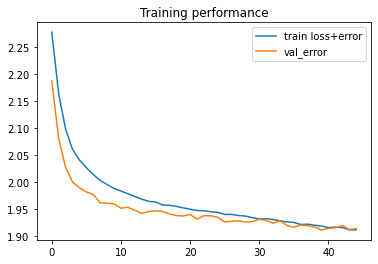

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

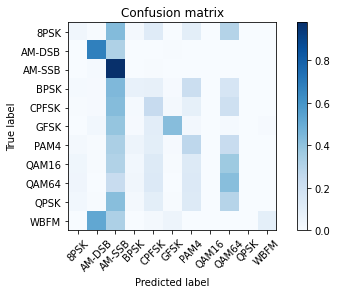

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08923169993950393


Overall Accuracy:  0.09121111446692842


Overall Accuracy:  0.09216451516061243


Overall Accuracy:  0.10595630050882969


Overall Accuracy:  0.11193807680857398


Overall Accuracy:  0.1345919610231425
Overall Accuracy:  0.1839080459770115


Overall Accuracy:  0.24551807961106048


Overall Accuracy:  0.30720530599939705


Overall Accuracy:  0.3870967741935484


Overall Accuracy:  0.3953560371517028


Overall Accuracy:  0.41782059000602045
Overall Accuracy:  0.41269349845201236


Overall Accuracy:  0.4029438822447102


Overall Accuracy:  0.4113671274961598
Overall Accuracy:  0.42200725513905685


Overall Accuracy:  0.4157814871016692


Overall Accuracy:  0.4035714285714286


Overall Accuracy:  0.40762991889456296


Overall Accuracy:  0.40146430750457596


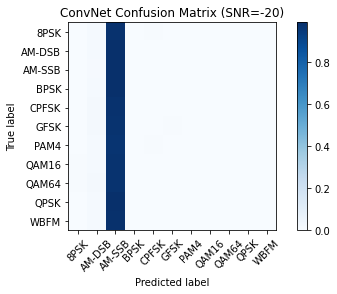

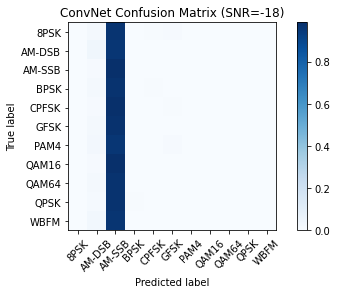

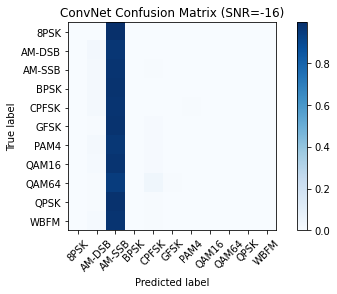

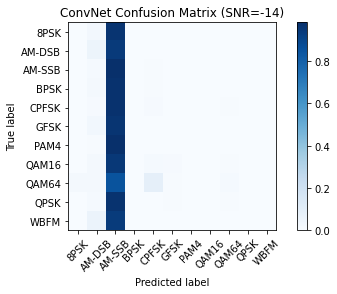

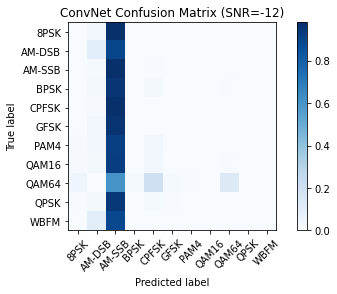

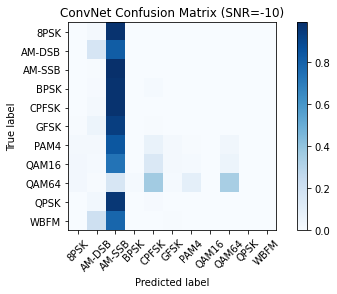

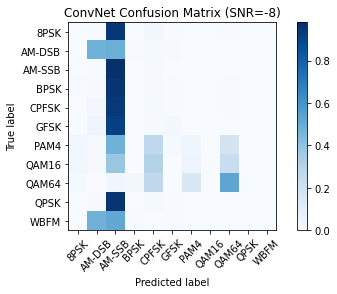

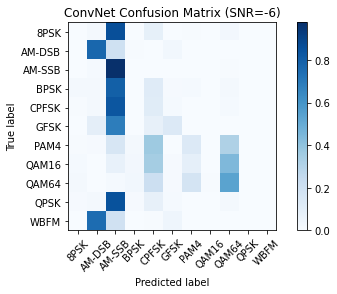

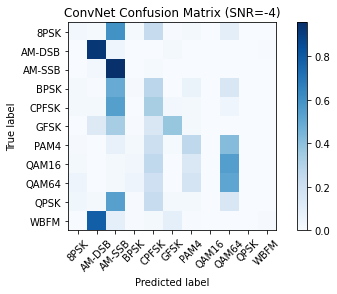

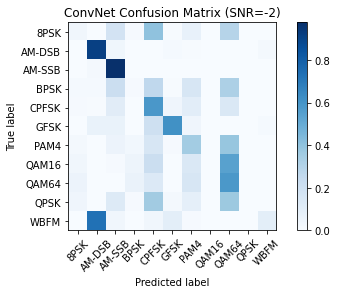

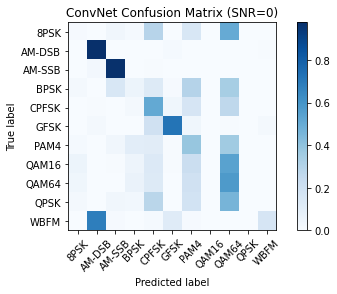

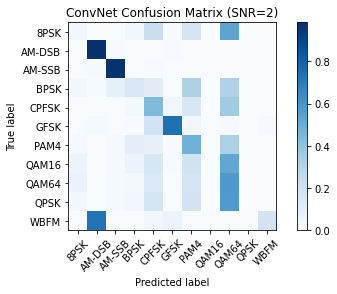

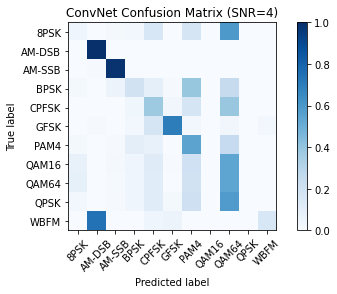

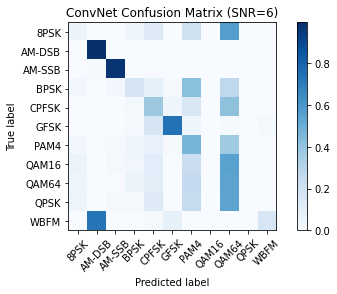

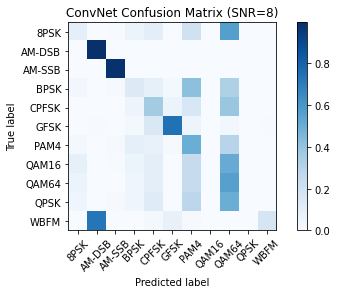

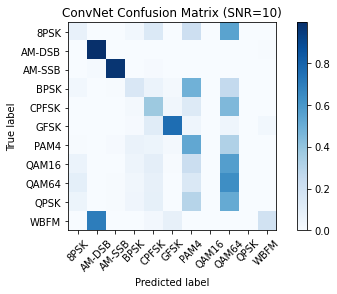

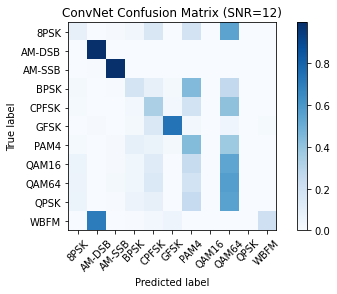

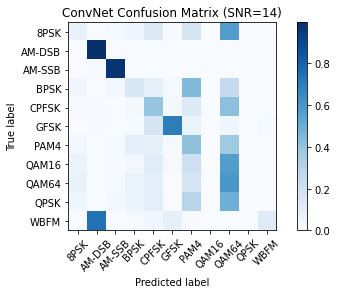

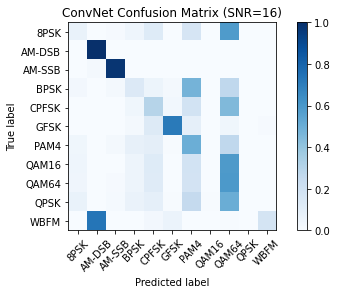

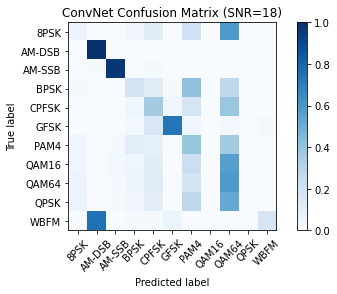

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,11,13,18,24,30,38,39,41,41,40,41,42,41,40,40,40


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

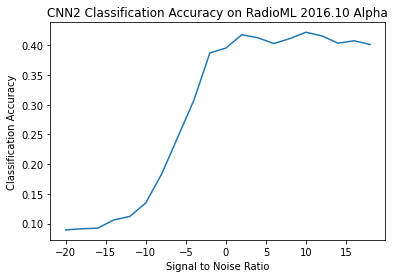

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")